# Import necessary dependencies

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sns
import model_evaluation_utils as meu
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from scipy import stats

%matplotlib inline

# Load and merge datasets

In [2]:
white_wine = pd.read_csv('winequality-white.csv', sep=';')
red_wine = pd.read_csv('winequality-red.csv', sep=';')

# add wine type as an attribute to the dataframe
red_wine['wine_type'] = 'red'   
white_wine['wine_type'] = 'white'

# bucket wine quality scores into qualitative quality labels
red_wine['quality_label'] = red_wine['quality'].apply(lambda value: 'low' 
                                                          if value <= 5 else 'medium' 
                                                              if value <= 7 else 'high')
red_wine['quality_label'] = pd.Categorical(red_wine['quality_label'], 
                                           categories=['low', 'medium', 'high'])

white_wine['quality_label'] = white_wine['quality'].apply(lambda value: 'low' 
                                                              if value <= 5 else 'medium' 
                                                                  if value <= 7 else 'high')

white_wine['quality_label'] = pd.Categorical(white_wine['quality_label'], 
                                             categories=['low', 'medium', 'high'])

# merge red and white wine datasets
wines = pd.concat([red_wine, white_wine])

# re-shuffle records just to randomize data points
wines = wines.sample(frac=1, random_state=24).reset_index(drop=True)

# Exploratory Data Analysis

In [3]:
#Get shape of the dataset
print(white_wine.shape, red_wine.shape)
print(wines.shape)

(4898, 14) (1599, 14)
(6497, 14)


In [4]:
# Check the first five columns of the dataframe
wines.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_type,quality_label
0,6.4,0.320,0.35,4.8,0.030,34.0,101.0,0.99120,3.36,0.60,12.5,8,white,high
1,6.7,0.480,0.49,2.9,0.030,28.0,122.0,0.98926,3.13,0.40,13.0,6,white,medium
2,5.7,0.245,0.33,1.1,0.049,28.0,150.0,0.99270,3.13,0.42,9.3,5,white,low
3,8.5,0.280,0.35,1.7,0.061,6.0,15.0,0.99524,3.30,0.74,11.8,7,red,medium
4,6.0,0.330,0.20,1.8,0.031,49.0,159.0,0.99190,3.41,0.53,11.0,6,white,medium


### Understanding Wine Attributes and Properties 

- **fixed acidity:** Acids are one of the fundamental properties of wine and contribute greatly to the taste of the wine. Reducing acids significantly might lead to wines tasting flat. 


- **volatile acidity:** These acids are to be distilled out from the wine before completing the production process. It is primarily constituted of acetic acid though other acids like lactic, formic and butyric acids might also be present. Excess of volatile acids are undesirable and lead to unpleasant flavor. 


- **citric acid:** This is one of the fixed acids which gives a wine its freshness. Usually most of it is consumed during the fermentation process and sometimes it is added separately to give the wine more freshness. 


- **residual sugar:** This typically refers to the natural sugar from grapes which remains after the fermentation process stops, or is stopped. 


- **chlorides:** This is usually a major contributor to saltiness in wine. 


- **free sulfur dioxide:** This is the part of the sulphur dioxide that when added to a wine is said to be free after the remaining part binds. They are also known as sulfites and too much of it is undesirable and gives a pungent odour. 


- **total sulfur dioxide:** This is the sum total of the bound and the free sulfur dioxide ($SO_2$).  This is mainly added to kill harmful bacteria and preserve quality and freshness. Excess of it can even kill good yeast and give out undesirable odour.


- **density:** This can be represented as a comparison of the weight of a specific volume of wine to an equivalent volume of water. It is generally used as a measure of the conversion of sugar to alcohol. 


- **pH:** Also known as the potential of hydrogen, this is a numeric scale to specify the acidity or basicity the wine. Fixed acidity contributes the most towards the pH of wines. With a pH of 7, pure water is neutral. Most wines have a pH between 2.9 and 3.9 and are therefore acidic.


- **sulphates:** These are mineral salts containing sulfur. They are connected to the fermentation process and affects the wine aroma and flavor.


- **alcohol:** Wine is an alcoholic beverage. Alcohol is formed as a result of yeast converting sugar during the fermentation process. 


- **quality:** Wine experts graded the wine quality between 0 (very bad) and 10 (very excellent). The eventual quality score is the median of at least three evaluations made by the same wine experts.


- **wine_type:** Since we originally had two datasets for red and white wine, we introduced this attribute in the final merged dataset which indicates the type of wine for each data point. A wine can either be a 'red' or a 'white' wine. One of the predictive models we will build would be such that we can predict the type of wine by looking at other wine attributes.


- **quality_label:** This is a derived attribute from the `quality` attribute. We bucket or group wine quality scores into three qualitative buckets namely low, medium and high. Wines with a quality score of 3, 4 & 5 are low quality, scores of 6 & 7 are medium quality and scores of 8 & 9 are high quality wines. We will also build another model to predict this wine quality label based on other wine attributes. 

## Descriptive Statistics

Statistics for residual sugar, total sulfur dioxide, sulphates, alcohol, volatile acidity, quality for the two types of wines.

In [5]:
subset_attributes = ['residual sugar', 'total sulfur dioxide', 'sulphates', 'alcohol', 'volatile acidity', 'quality']
rs = round(red_wine[subset_attributes].describe(),2)
ws = round(white_wine[subset_attributes].describe(),2)
pd.concat([rs, ws], axis=1, keys=['Red Wine Statistics', 'White Wine Statistics'])

Red Wine Statistics                                          \
           residual sugar total sulfur dioxide sulphates  alcohol   
count             1599.00              1599.00   1599.00  1599.00   
mean                 2.54                46.47      0.66    10.42   
std                  1.41                32.90      0.17     1.07   
min                  0.90                 6.00      0.33     8.40   
25%                  1.90                22.00      0.55     9.50   
50%                  2.20                38.00      0.62    10.20   
75%                  2.60                62.00      0.73    11.10   
max                 15.50               289.00      2.00    14.90   

                                White Wine Statistics                       \
      volatile acidity  quality        residual sugar total sulfur dioxide   
count          1599.00  1599.00               4898.00              4898.00   
mean              0.53     5.64                  6.39               138.36   
std               0.18     0.81                  5.07                42.50   
min               0.12     3.00                  0.60                 9.00   
25%               0.39     5.00                  1.70               108.00   
50%               0.52     6.00                  5.20               134.00   
75%               0.64     6.00                  9.90               167.00   
max               1.58     8.00                 65.80               440.00   

                                                    
      sulphates  alcohol volatile acidity  quality  
count   4898.00  4898.00          4898.00  4898.00  
mean       0.49    10.51             0.28     5.88  
std        0.11     1.23             0.10     0.89  
min        0.22     8.00             0.08     3.00  
25%        0.41     9.50             0.21     5.00  
50%        0.47    10.40             0.26     6.00  
75%        0.55    11.40             0.32     6.00  
max        1.08    14.20             1.10     9.00

Statistics for residual sugar, total sulfur dioxide, sulphates, alcohol, volatile acidity, quality for the three qualities of wines.

In [6]:
subset_attributes = ['alcohol', 'volatile acidity', 'pH', 'quality']
ls = round(wines[wines['quality_label'] == 'low'][subset_attributes].describe(),2)
ms = round(wines[wines['quality_label'] == 'medium'][subset_attributes].describe(),2)
hs = round(wines[wines['quality_label'] == 'high'][subset_attributes].describe(),2)
pd.concat([ls, ms, hs], axis=1, keys=['Low Quality Wine', 'Medium Quality Wine', 'High Quality Wine'])

Low Quality Wine                                    Medium Quality Wine  \
               alcohol volatile acidity       pH  quality             alcohol   
count          2384.00          2384.00  2384.00  2384.00             3915.00   
mean              9.87             0.40     3.21     4.88               10.81   
std               0.84             0.19     0.16     0.36                1.20   
min               8.00             0.10     2.74     3.00                8.40   
25%               9.30             0.26     3.11     5.00                9.80   
50%               9.60             0.34     3.20     5.00               10.80   
75%              10.40             0.50     3.31     5.00               11.70   
max              14.90             1.58     3.90     5.00               14.20   

                                         High Quality Wine                   \
      volatile acidity       pH  quality           alcohol volatile acidity   
count          3915.00  3915.00  3915.00            198.00           198.00   
mean              0.31     3.22     6.28             11.69             0.29   
std               0.14     0.16     0.45              1.27             0.12   
min               0.08     2.72     6.00              8.50             0.12   
25%               0.21     3.11     6.00             11.00             0.21   
50%               0.27     3.21     6.00             12.00             0.28   
75%               0.36     3.33     7.00             12.60             0.35   
max               1.04     4.01     7.00             14.00             0.85   

                       
           pH quality  
count  198.00  198.00  
mean     3.23    8.03  
std      0.16    0.16  
min      2.88    8.00  
25%      3.13    8.00  
50%      3.23    8.00  
75%      3.33    8.00  
max      3.72    9.00

 ## Variation in Alcohol levels, pH levels by wine quality
 Testing to check if there are variations in the three quality levels using Anova

In [7]:
F, p = stats.f_oneway(wines[wines['quality_label'] == 'low']['alcohol'], 
                      wines[wines['quality_label'] == 'medium']['alcohol'], 
                      wines[wines['quality_label'] == 'high']['alcohol'])
print('ANOVA test for mean alcohol levels across wine samples with different quality ratings')
print('F Statistic:', F, '\tp-value:', p)

F, p = stats.f_oneway(wines[wines['quality_label'] == 'low']['pH'], 
                      wines[wines['quality_label'] == 'medium']['pH'], 
                      wines[wines['quality_label'] == 'high']['pH'])
print('\nANOVA test for mean pH levels across wine samples with different quality ratings')
print('F Statistic:', F, '\tp-value:', p)

ANOVA test for mean alcohol levels across wine samples with different quality ratings
F Statistic: 673.0745347231034 	p-value: 2.2715337450621843e-266

ANOVA test for mean pH levels across wine samples with different quality ratings
F Statistic: 1.2363860803545201 	p-value: 0.2905002779768688


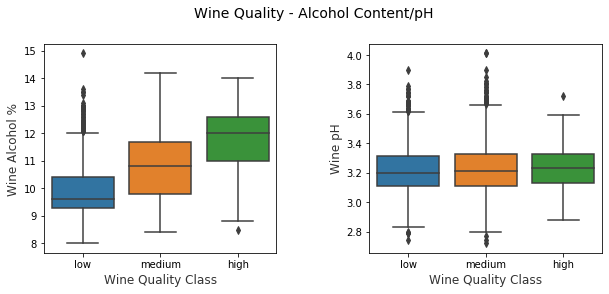

In [50]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
f.suptitle('Wine Quality - Alcohol Content/pH', fontsize=14)
f.subplots_adjust(top=0.85, wspace=0.4)

sns.boxplot(x="quality_label", y="alcohol", data=wines, ax=ax1)
ax1.set_xlabel("Wine Quality Class",size = 12,alpha=0.8)
ax1.set_ylabel("Wine Alcohol %",size = 12,alpha=0.8)

sns.boxplot(x="quality_label", y="pH", data=wines, ax=ax2)
ax2.set_xlabel("Wine Quality Class", size = 12,alpha=0.8)
ax2.set_ylabel("Wine pH",size = 12,alpha=0.8)
plt.savefig('Wine_Alcohol.png')

Alcohol level varies but the level of pH is same among the three groups, let check this visually.
From the graphs above we can see that there is a difference in the alcohol percentage in the three groups. 
The wine pH does not seem to vary among the three classes of wine.

## Distribution of features in the wine dataset

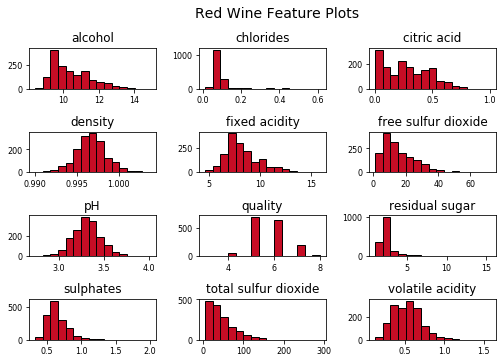

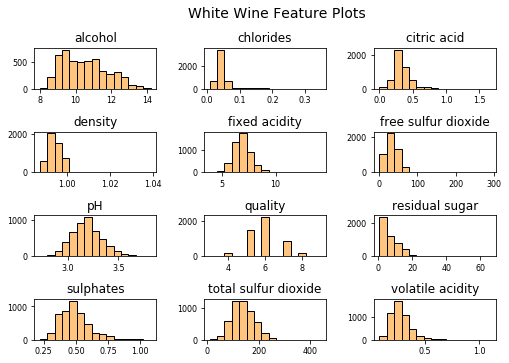

In [9]:
red_wine.hist(bins=15, color='#C60D25', edgecolor='black', linewidth=1.0,
              xlabelsize=8, ylabelsize=8, grid=False)    
plt.tight_layout(rect=(0, 0, 1.2, 1.2))   
rt = plt.suptitle('Red Wine Feature Plots', x=0.65, y=1.25, fontsize=14)  

white_wine.hist(bins=15, color='#FFC47D', edgecolor='black', linewidth=1.0,
              xlabelsize=8, ylabelsize=8, grid=False)    
plt.tight_layout(rect=(0, 0, 1.2, 1.2))   
wt = plt.suptitle('White Wine Feature Plots', x=0.65, y=1.25, fontsize=14)  

There appears to be differences in the levels of residual sugar, total sulphur dioxide and sulphate levels. 
We can check by ploting their distributions side by side. 

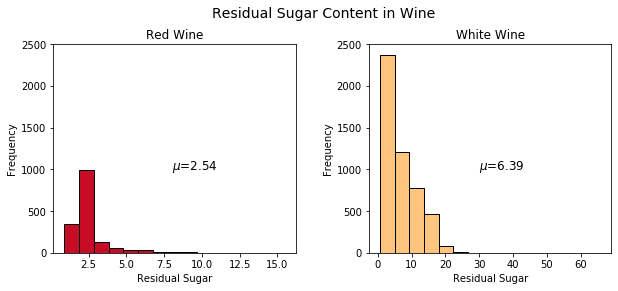

In [10]:
fig = plt.figure(figsize = (10,4))
title = fig.suptitle("Residual Sugar Content in Wine", fontsize=14)
fig.subplots_adjust(top=0.85, wspace=0.3)

ax1 = fig.add_subplot(1,2, 1)
ax1.set_title("Red Wine")
ax1.set_xlabel("Residual Sugar")
ax1.set_ylabel("Frequency") 
ax1.set_ylim([0, 2500])
ax1.text(8, 1000, r'$\mu$='+str(round(red_wine['residual sugar'].mean(),2)), 
         fontsize=12)
r_freq, r_bins, r_patches = ax1.hist(red_wine['residual sugar'], color='#C60D25', bins=15,
                                    edgecolor='black', linewidth=1)

ax2 = fig.add_subplot(1,2, 2)
ax2.set_title("White Wine")
ax2.set_xlabel("Residual Sugar")
ax2.set_ylabel("Frequency")
ax2.set_ylim([0, 2500])
ax2.text(30, 1000, r'$\mu$='+str(round(white_wine['residual sugar'].mean(),2)), 
         fontsize=12)
w_freq, w_bins, w_patches = ax2.hist(white_wine['residual sugar'], color='#FFC47D', bins=15,
                                    edgecolor='black', linewidth=1)

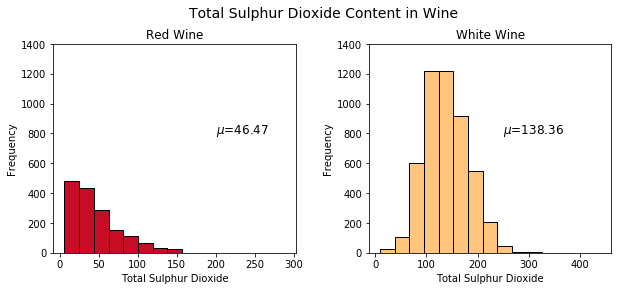

In [11]:
fig = plt.figure(figsize = (10,4))
title = fig.suptitle("Total Sulphur Dioxide Content in Wine", fontsize=14)
fig.subplots_adjust(top=0.85, wspace=0.3)

ax1 = fig.add_subplot(1,2, 1)
ax1.set_title("Red Wine")
ax1.set_xlabel("Total Sulphur Dioxide")
ax1.set_ylabel("Frequency") 
ax1.set_ylim([0, 1400])
ax1.text(200, 800, r'$\mu$='+str(round(red_wine['total sulfur dioxide'].mean(),2)), 
         fontsize=12)
r_freq, r_bins, r_patches = ax1.hist(red_wine['total sulfur dioxide'], color='#C60D25', bins=15,
                                    edgecolor='black', linewidth=1)

ax2 = fig.add_subplot(1,2, 2)
ax2.set_title("White Wine")
ax2.set_xlabel("Total Sulphur Dioxide")
ax2.set_ylabel("Frequency")
ax2.set_ylim([0, 1400])
ax2.text(250, 800, r'$\mu$='+str(round(white_wine['total sulfur dioxide'].mean(),2)), 
         fontsize=12)
w_freq, w_bins, w_patches = ax2.hist(white_wine['total sulfur dioxide'], color='#FFC47D', bins=15,
                                    edgecolor='black', linewidth=1)

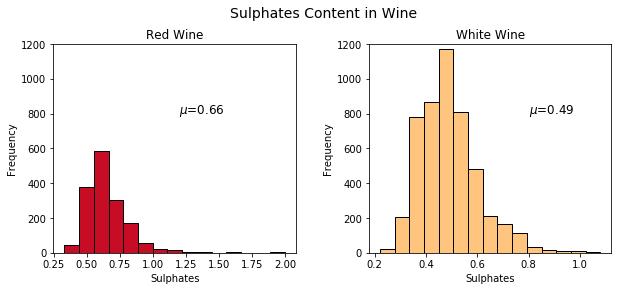

In [12]:
fig = plt.figure(figsize = (10,4))
title = fig.suptitle("Sulphates Content in Wine", fontsize=14)
fig.subplots_adjust(top=0.85, wspace=0.3)

ax1 = fig.add_subplot(1,2, 1)
ax1.set_title("Red Wine")
ax1.set_xlabel("Sulphates")
ax1.set_ylabel("Frequency") 
ax1.set_ylim([0, 1200])
ax1.text(1.2, 800, r'$\mu$='+str(round(red_wine['sulphates'].mean(),2)), 
         fontsize=12)
r_freq, r_bins, r_patches = ax1.hist(red_wine['sulphates'], color='#C60D25', bins=15,
                                    edgecolor='black', linewidth=1)

ax2 = fig.add_subplot(1,2, 2)
ax2.set_title("White Wine")
ax2.set_xlabel("Sulphates")
ax2.set_ylabel("Frequency")
ax2.set_ylim([0, 1200])
ax2.text(0.8, 800, r'$\mu$='+str(round(white_wine['sulphates'].mean(),2)), 
         fontsize=12)
w_freq, w_bins, w_patches = ax2.hist(white_wine['sulphates'], color='#FFC47D', bins=15,
                                    edgecolor='black', linewidth=1)

There does appear to be a difference in the distributions of residual sugar content, total sulphur dioxide and sulphate content among the two types of wines. We will plot bar plots to show us the distribution of wine samples based on type and
quality.

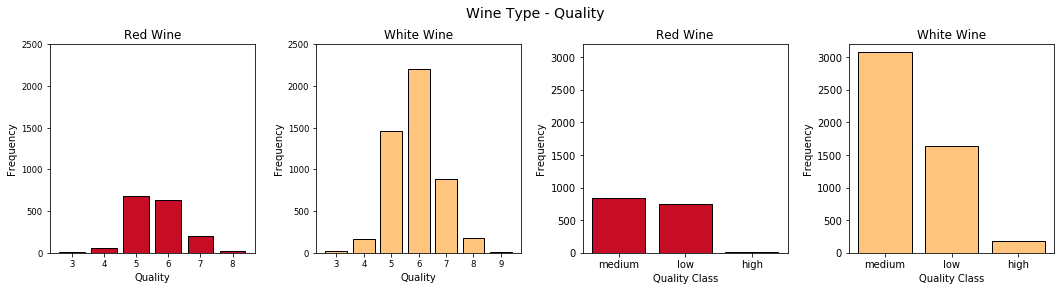

In [13]:
fig = plt.figure(figsize = (18, 4))
title = fig.suptitle("Wine Type - Quality", fontsize=14)
fig.subplots_adjust(top=0.85, wspace=0.3)

ax1 = fig.add_subplot(1,4, 1)
ax1.set_title("Red Wine")
ax1.set_xlabel("Quality")
ax1.set_ylabel("Frequency") 
rw_q = red_wine['quality'].value_counts()
rw_q = (list(rw_q.index), list(rw_q.values))
ax1.set_ylim([0, 2500])
ax1.tick_params(axis='both', which='major', labelsize=8.5)
bar1 = ax1.bar(rw_q[0], rw_q[1], color='#C60D25', 
        edgecolor='black', linewidth=1)


ax2 = fig.add_subplot(1,4, 2)
ax2.set_title("White Wine")
ax2.set_xlabel("Quality")
ax2.set_ylabel("Frequency") 
ww_q = white_wine['quality'].value_counts()
ww_q = (list(ww_q.index), list(ww_q.values))
ax2.set_ylim([0, 2500])
ax2.tick_params(axis='both', which='major', labelsize=8.5)
bar2 = ax2.bar(ww_q[0], ww_q[1], color='#FFC47D', 
        edgecolor='black', linewidth=1)

ax3 = fig.add_subplot(1,4, 3)
ax3.set_title("Red Wine")
ax3.set_xlabel("Quality Class")
ax3.set_ylabel("Frequency") 
rw_q = red_wine['quality_label'].value_counts()
rw_q = (list(rw_q.index), list(rw_q.values))
ax3.set_ylim([0, 3200])
bar3 = ax3.bar(list(range(len(rw_q[0]))), rw_q[1], color='#C60D25', 
        edgecolor='black', linewidth=1, tick_label =rw_q[0])

ax4 = fig.add_subplot(1,4, 4)
ax4.set_title("White Wine")
ax4.set_xlabel("Quality Class")
ax4.set_ylabel("Frequency") 
ww_q = white_wine['quality_label'].value_counts()
ww_q = (list(ww_q.index), list(ww_q.values))
ax4.set_ylim([0, 3200])
bar4 = ax4.bar(list(range(len(ww_q[0]))), ww_q[1], color='#FFC47D', 
        edgecolor='black', linewidth=1, tick_label =ww_q[0])

It is quite evident that high quality wine samples are far less as compared to low and medium
quality wine samples.

## Analysing patterns in wine features

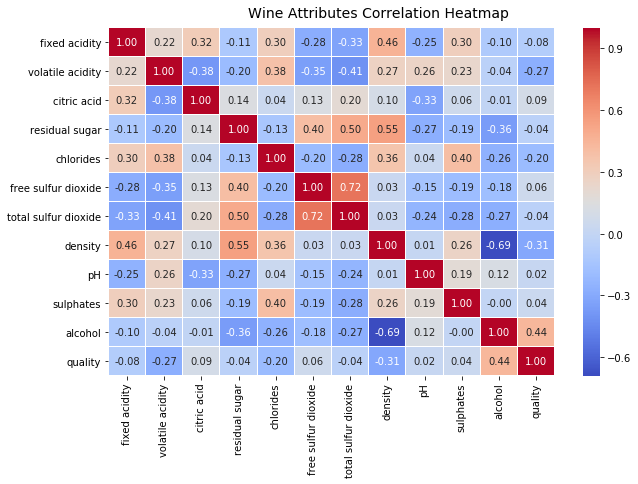

In [14]:
f, ax = plt.subplots(figsize=(10, 6))
corr = wines.corr()
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
            linewidths=.05)
f.subplots_adjust(top=0.93)
t= f.suptitle('Wine Attributes Correlation Heatmap', fontsize=14)

We build a pairwise correlation plot depicting the correlation coefficient between
each pair of features in the dataset. We build a correlation matrix and plot it 
in the form of an easy-to-interpret heatmap. 
We can see a strong negative correlation between density and alcohol and a strong positive correlation
between total and free sulfur dioxide, which is expected.

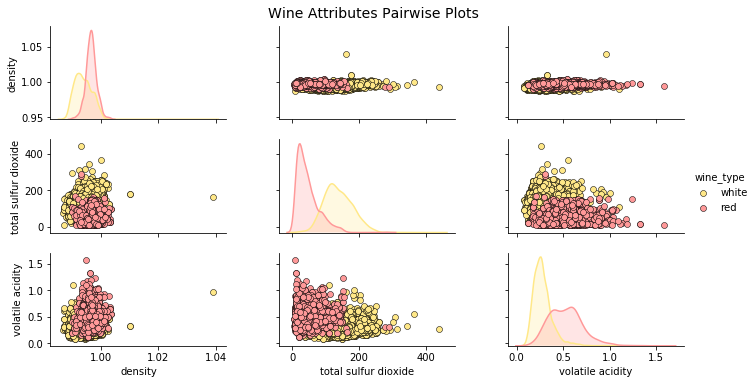

In [15]:
cols = ['wine_type', 'density', 'total sulfur dioxide', 'volatile acidity']
pp = sns.pairplot(wines[cols], hue='wine_type', height=1.8, aspect=1.8, 
                  palette={"red": "#FF9999", "white": "#FFE888"},
                  plot_kws=dict(edgecolor="black", linewidth=0.5))
fig = pp.fig 
fig.subplots_adjust(top=0.93, wspace=0.3)
t = fig.suptitle('Wine Attributes Pairwise Plots', fontsize=14)

We visualize patterns and relationships among multiple variables using pairwise plots
We obtain the following observations:

- Presence of higher total sulfur dioxide levels in white wines as compared to red wines
- Presence of higher volatile acid levels in red wines as compared to white wines
- Density of red wine appears to be more than white wine

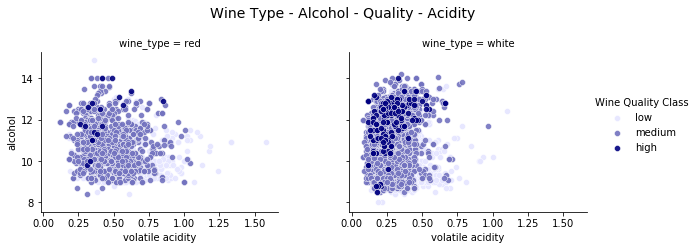

In [51]:
g = sns.FacetGrid(wines, col="wine_type", hue='quality_label', 
                  col_order=['red', 'white'], hue_order=['low', 'medium', 'high'],
                  aspect=1.2, height=3.5, palette=sns.light_palette('navy', 3))
g.map(plt.scatter, "volatile acidity", "alcohol", alpha=0.9, 
      edgecolor='white', linewidth=0.5)
fig = g.fig 
fig.subplots_adjust(top=0.8, wspace=0.3)
fig.suptitle('Wine Type - Alcohol - Quality - Acidity', fontsize=14)
l = g.add_legend(title='Wine Quality Class')
plt.savefig('Wine_Quality_Class.png')

We try to visualize relationships between wine type, quality ratings, volatile acidity, and alcohol volume levels.
Higher quality wine samples (depicted by darker shades) have lower levels of volatile acidity and higher levels of alcohol content as compared to wine samples with medium and low ratings. We can also see that volatile acidity
levels are slightly lower in white wine samples overall as compared to red wine samples.

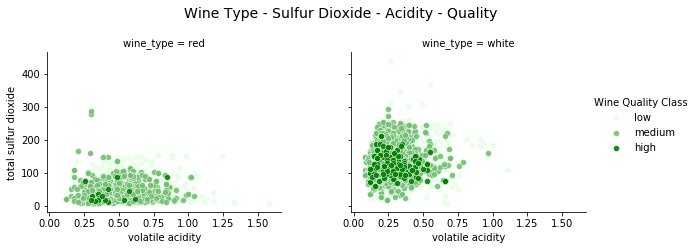

In [17]:
g = sns.FacetGrid(wines, col="wine_type", hue='quality_label', 
                  col_order=['red', 'white'], hue_order=['low', 'medium', 'high'],
                  aspect=1.2, height=3.5, palette=sns.light_palette('green', 3))
g.map(plt.scatter, "volatile acidity", "total sulfur dioxide", alpha=0.9, 
      edgecolor='white', linewidth=0.5)
fig = g.fig 
fig.subplots_adjust(top=0.8, wspace=0.3)
fig.suptitle('Wine Type - Sulfur Dioxide - Acidity - Quality', fontsize=14)
l = g.add_legend(title='Wine Quality Class')

We can interpret that volatile acidity as well as total sulfur dioxide is considerably lower in high quality wine samples.
Also, total sulfur dioxide is considerable more in white wine samples as compared to red wine samples. However, volatile acidity levels are slightly lower in white wine samples as compared to red wine samples we also observed in the previous plot. 

## Predictive Modelling
Now that we have an idea of the features in our dataset, we move on to building predictive models for
predicting the wine types and quality rating based on the features in our dataset. 

We build two main classification systems 
- Prediction system for wine type (red or white wine)
- Prediction system for wine quality rating (low, medium, or high)

## Predicting Wine Types

### Prepare training and testing datasets

In [18]:
wtp_features = wines.iloc[:,:-3]
wtp_feature_names = wtp_features.columns
wtp_class_labels = np.array(wines['wine_type'])

wtp_train_X, wtp_test_X, wtp_train_y, wtp_test_y = train_test_split(wtp_features, wtp_class_labels, 
                                                                    test_size=0.3, random_state=24)

print(Counter(wtp_train_y), Counter(wtp_test_y))
print('Features:', list(wtp_feature_names))

Counter({'white': 3447, 'red': 1100}) Counter({'white': 1451, 'red': 499})
Features: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']


## Feature scaling

In [19]:
# Define the scaler 
wtp_ss = StandardScaler().fit(wtp_train_X)

# Scale the train set
wtp_train_SX = wtp_ss.transform(wtp_train_X)

# Scale the test set
wtp_test_SX = wtp_ss.transform(wtp_test_X)

## Train a Model using Logistic Regression

In [20]:
from sklearn.linear_model import LogisticRegression

wtp_lr = LogisticRegression(solver='lbfgs')
wtp_lr.fit(wtp_train_SX, wtp_train_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

## Predict and Evaluate Model Performance

In [21]:
wtp_lr_predictions = wtp_lr.predict(wtp_test_SX)
meu.display_model_performance_metrics(true_labels=wtp_test_y, predicted_labels=wtp_lr_predictions, 
                                      classes=['red', 'white'])

Model Performance metrics:
------------------------------
Accuracy: 0.9928
Precision: 0.9928
Recall: 0.9928
F1 Score: 0.9928

Model Classification report:
------------------------------
              precision    recall  f1-score   support

         red       0.99      0.98      0.99       499
       white       0.99      1.00      1.00      1451

    accuracy                           0.99      1950
   macro avg       0.99      0.99      0.99      1950
weighted avg       0.99      0.99      0.99      1950


Prediction Confusion Matrix:
------------------------------
              Predicted:      
                     red white
Actual: red          491     8
        white          6  1445


## Train a Model using Deep Learning (MLP)

### Encode Response class labels 

In [22]:
le = LabelEncoder()
le.fit(wtp_train_y)
# encode wine type labels
wtp_train_ey = le.transform(wtp_train_y)
wtp_test_ey = le.transform(wtp_test_y)

### Build & Compile DNN Model Architecture

In [23]:
from keras.models import Sequential
from keras.layers import Dense

wtp_dnn_model = Sequential()
wtp_dnn_model.add(Dense(16, activation='relu', input_shape=(11,)))
wtp_dnn_model.add(Dense(16, activation='relu'))
wtp_dnn_model.add(Dense(16, activation='relu'))
wtp_dnn_model.add(Dense(1, activation='sigmoid'))

wtp_dnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


### Train the Model

In [24]:
history = wtp_dnn_model.fit(wtp_train_SX, wtp_train_ey, epochs=10, batch_size=5, 
                            shuffle=True, validation_split=0.1, verbose=1)

Instructions for updating:
Use tf.cast instead.
Train on 4092 samples, validate on 455 samples
Epoch 1/10
4092/4092 [==============================] - 3s 833us/step - loss: 0.1348 - acc: 0.9585 - val_loss: 0.0218 - val_acc: 0.9978
Epoch 2/10
4092/4092 [==============================] - 2s 484us/step - loss: 0.0326 - acc: 0.9932 - val_loss: 0.0165 - val_acc: 0.9978
Epoch 3/10
4092/4092 [==============================] - 2s 494us/step - loss: 0.0254 - acc: 0.9954 - val_loss: 0.0157 - val_acc: 0.9978
Epoch 4/10
4092/4092 [==============================] - 2s 476us/step - loss: 0.0201 - acc: 0.9958 - val_loss: 0.0143 - val_acc: 0.9978
Epoch 5/10
4092/4092 [==============================] - 2s 469us/step - loss: 0.0173 - acc: 0.9968 - val_loss: 0.0138 - val_acc: 0.9978
Epoch 6/10
4092/4092 [==============================] - 2s 471us/step - loss: 0.0149 - acc: 0.9961 - val_loss: 0.0132 - val_acc: 0.9978
Epoch 7/10
4092/4092 [==============================] - 2s 469us/step - loss: 0.0120 - ac

### Predict on Test dataset

In [25]:
wtp_dnn_ypred = wtp_dnn_model.predict_classes(wtp_test_SX)
wtp_dnn_predictions = le.inverse_transform(wtp_dnn_ypred.ravel()) 

### Evaluate Model Performance

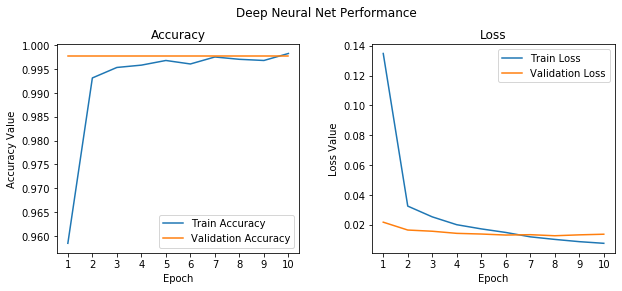

In [26]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
t = f.suptitle('Deep Neural Net Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epochs = list(range(1,11))
ax1.plot(epochs, history.history['acc'], label='Train Accuracy')
ax1.plot(epochs, history.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(epochs)
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epochs, history.history['loss'], label='Train Loss')
ax2.plot(epochs, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(epochs)
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [27]:
meu.display_model_performance_metrics(true_labels=wtp_test_y, predicted_labels=wtp_dnn_predictions, 
                                      classes=['red', 'white'])

Model Performance metrics:
------------------------------
Accuracy: 0.9933
Precision: 0.9933
Recall: 0.9933
F1 Score: 0.9933

Model Classification report:
------------------------------
              precision    recall  f1-score   support

         red       0.99      0.98      0.99       499
       white       0.99      1.00      1.00      1451

    accuracy                           0.99      1950
   macro avg       0.99      0.99      0.99      1950
weighted avg       0.99      0.99      0.99      1950


Prediction Confusion Matrix:
------------------------------
              Predicted:      
                     red white
Actual: red          491     8
        white          5  1446


# Model Interpretation
## View Feature importances

[11/11] features ████████████████████ Time elapsed: 0 seconds

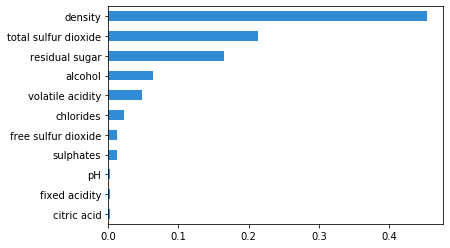

In [28]:
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel

wtp_interpreter = Interpretation(wtp_test_SX, feature_names=wtp_features.columns)
wtp_im_model = InMemoryModel(wtp_lr.predict_proba, examples=wtp_train_SX, target_names=wtp_lr.classes_)
plots = wtp_interpreter.feature_importance.plot_feature_importance(wtp_im_model, ascending=False)

## View model ROC curve

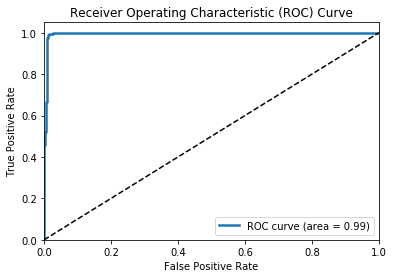

In [29]:
meu.plot_model_roc_curve(wtp_lr, wtp_test_SX, wtp_test_y)

# Predicting Wine Quality
## Prepare Training and Testing datasets

In [30]:
wqp_features = wines.iloc[:,:-3]
wqp_class_labels = np.array(wines['quality_label'])
wqp_label_names = ['low', 'medium', 'high']
wqp_feature_names = list(wqp_features.columns)
wqp_train_X, wqp_test_X, wqp_train_y, wqp_test_y = train_test_split(wqp_features, wqp_class_labels, 
                                                                    test_size=0.3, random_state=24)

print(Counter(wqp_train_y), Counter(wqp_test_y))
print('Features:', wqp_feature_names)

Counter({'medium': 2754, 'low': 1648, 'high': 145}) Counter({'medium': 1161, 'low': 736, 'high': 53})
Features: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']


## Feature Scaling


In [31]:
# Define the scaler 
wqp_ss = StandardScaler().fit(wqp_train_X)

# Scale the train set
wqp_train_SX = wqp_ss.transform(wqp_train_X)

# Scale the test set
wqp_test_SX = wqp_ss.transform(wqp_test_X)

## Train, Predict & Evaluate Model using Decision Tree 


In [32]:
from sklearn.tree import DecisionTreeClassifier

wqp_dt = DecisionTreeClassifier()
wqp_dt.fit(wqp_train_SX, wqp_train_y)

wqp_dt_predictions = wqp_dt.predict(wqp_test_SX)

meu.display_model_performance_metrics(true_labels=wqp_test_y, predicted_labels=wqp_dt_predictions, 
                                      classes=wqp_label_names)

Model Performance metrics:
------------------------------
Accuracy: 0.72
Precision: 0.7232
Recall: 0.72
F1 Score: 0.7214

Model Classification report:
------------------------------
              precision    recall  f1-score   support

         low       0.68      0.67      0.67       736
      medium       0.77      0.77      0.77      1161
        high       0.31      0.40      0.35        53

    accuracy                           0.72      1950
   macro avg       0.59      0.61      0.60      1950
weighted avg       0.72      0.72      0.72      1950


Prediction Confusion Matrix:
------------------------------
               Predicted:            
                      low medium high
Actual: low           494    238    4
        medium        229    889   43
        high            5     27   21


## View Feature Importances from Decision Tree Model

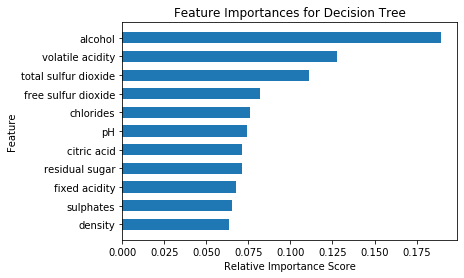

In [33]:
wqp_dt_feature_importances = wqp_dt.feature_importances_
wqp_dt_feature_names, wqp_dt_feature_scores = zip(*sorted(zip(wqp_feature_names, wqp_dt_feature_importances), 
                                                          key=lambda x: x[1]))
y_position = list(range(len(wqp_dt_feature_names)))
plt.barh(y_position, wqp_dt_feature_scores, height=0.6, align='center')
plt.yticks(y_position , wqp_dt_feature_names)
plt.xlabel('Relative Importance Score')
plt.ylabel('Feature')
t = plt.title('Feature Importances for Decision Tree')

## Visualize the Decision Tree

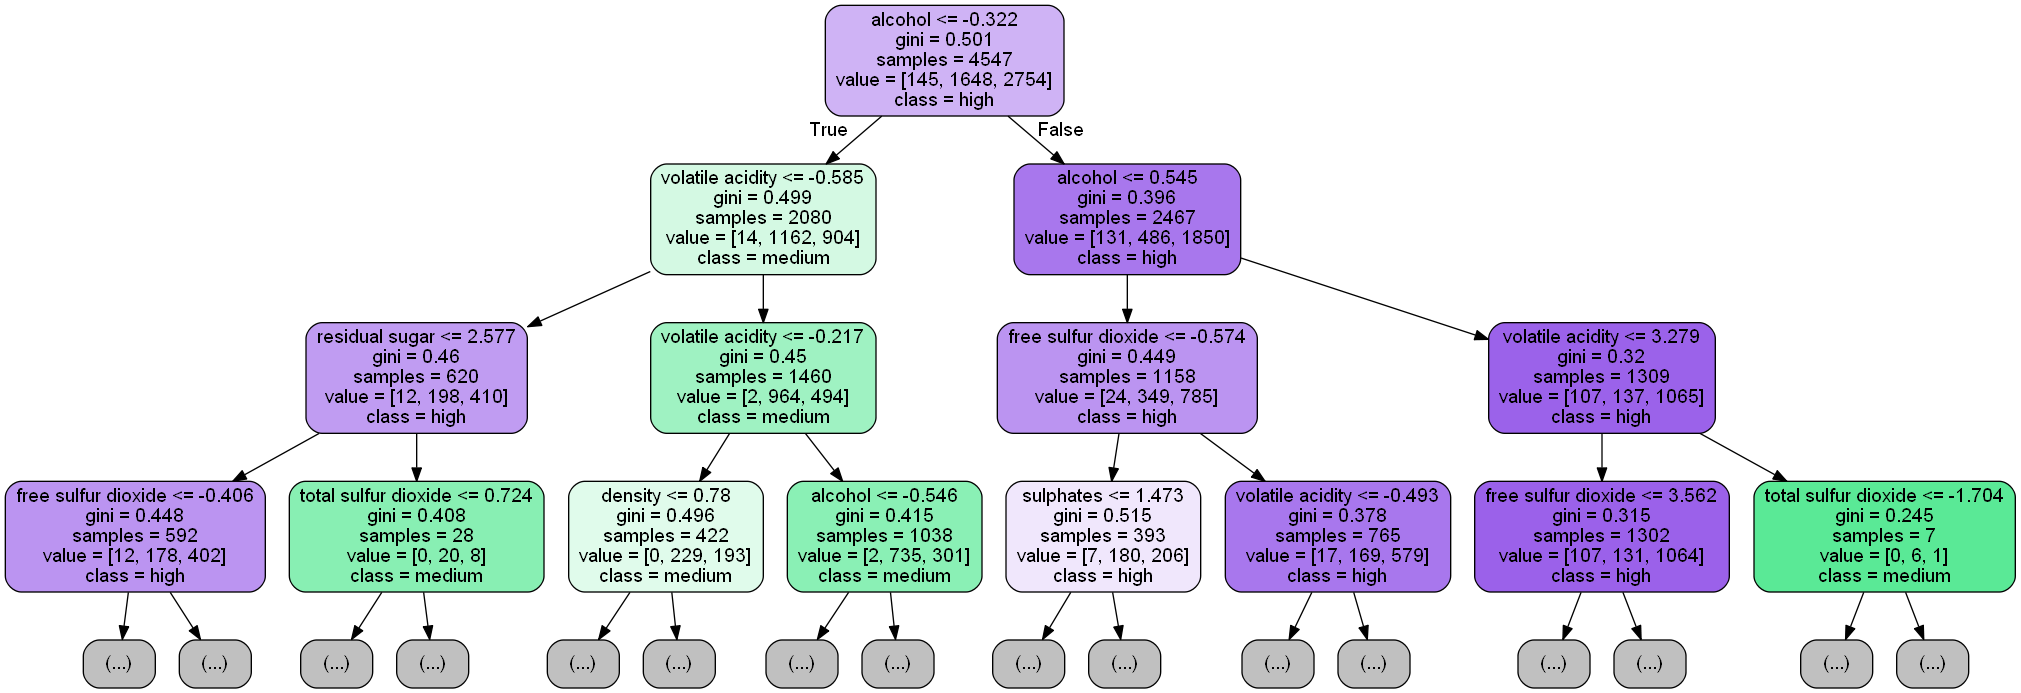

In [34]:
from graphviz import Source
from sklearn import tree
from IPython.display import Image

graph = Source(tree.export_graphviz(wqp_dt, out_file=None, class_names=wqp_label_names,
                                    filled=True, rounded=True, special_characters=False,
                                    feature_names=wqp_feature_names, max_depth=3))
png_data = graph.pipe(format='png')
with open('dtree_structure.png','wb') as f:
    f.write(png_data)

Image(png_data)

## Train, Predict & Evaluate Model using Random Forests

In [35]:
from sklearn.ensemble import RandomForestClassifier
# train the model
wqp_rf = RandomForestClassifier()
wqp_rf.fit(wqp_train_SX, wqp_train_y)
# predict and evaluate performance
wqp_rf_predictions = wqp_rf.predict(wqp_test_SX)
meu.display_model_performance_metrics(true_labels=wqp_test_y, predicted_labels=wqp_rf_predictions, 
                                      classes=wqp_label_names)

C:\Users\Avi\Anaconda3\envs\tf\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Model Performance metrics:
------------------------------
Accuracy: 0.7774
Precision: 0.7746
Recall: 0.7774
F1 Score: 0.7747

Model Classification report:
------------------------------
              precision    recall  f1-score   support

         low       0.74      0.74      0.74       736
      medium       0.81      0.83      0.82      1161
        high       0.59      0.30      0.40        53

    accuracy                           0.78      1950
   macro avg       0.71      0.62      0.65      1950
weighted avg       0.77      0.78      0.77      1950


Prediction Confusion Matrix:
------------------------------
               Predicted:            
                      low medium high
Actual: low           542    193    1
        medium        193    958   10
        high            1     36   16


## Hyperparameter tuning with Grid Search & Cross Validation

In [36]:
print(wqp_rf.get_params())

{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


### Get the best hyperparameter values

In [37]:
from sklearn.model_selection import GridSearchCV

param_grid = {
                'n_estimators': [100, 200, 300, 500], 
                'max_features': ['auto', None, 'log2']    
              }

wqp_clf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5,
                       scoring='accuracy')
wqp_clf.fit(wqp_train_SX, wqp_train_y)
print(wqp_clf.best_params_)

{'max_features': 'auto', 'n_estimators': 200}


### View grid search results

In [38]:
results = wqp_clf.cv_results_
for param, score_mean, score_sd in zip(results['params'], results['mean_test_score'], results['std_test_score']):
    print(param, round(score_mean, 4), round(score_sd, 4))

{'max_features': 'auto', 'n_estimators': 100} 0.788 0.0181
{'max_features': 'auto', 'n_estimators': 200} 0.7937 0.0145
{'max_features': 'auto', 'n_estimators': 300} 0.7865 0.0153
{'max_features': 'auto', 'n_estimators': 500} 0.792 0.0164
{'max_features': None, 'n_estimators': 100} 0.7847 0.0155
{'max_features': None, 'n_estimators': 200} 0.7849 0.0142
{'max_features': None, 'n_estimators': 300} 0.786 0.0159
{'max_features': None, 'n_estimators': 500} 0.7873 0.0145
{'max_features': 'log2', 'n_estimators': 100} 0.788 0.0181
{'max_features': 'log2', 'n_estimators': 200} 0.7937 0.0145
{'max_features': 'log2', 'n_estimators': 300} 0.7865 0.0153
{'max_features': 'log2', 'n_estimators': 500} 0.792 0.0164


### Train, Predict & Evaluate Random Forest Model with tuned hyperparameters

In [39]:
wqp_rf = RandomForestClassifier(n_estimators=200, max_features='auto', random_state=42)
wqp_rf.fit(wqp_train_SX, wqp_train_y)

wqp_rf_predictions = wqp_rf.predict(wqp_test_SX)
meu.display_model_performance_metrics(true_labels=wqp_test_y, predicted_labels=wqp_rf_predictions, 
                                      classes=wqp_label_names)

Model Performance metrics:
------------------------------
Accuracy: 0.8036
Precision: 0.8063
Recall: 0.8036
F1 Score: 0.7992

Model Classification report:
------------------------------
              precision    recall  f1-score   support

         low       0.79      0.72      0.75       736
      medium       0.81      0.88      0.84      1161
        high       1.00      0.34      0.51        53

    accuracy                           0.80      1950
   macro avg       0.87      0.65      0.70      1950
weighted avg       0.81      0.80      0.80      1950


Prediction Confusion Matrix:
------------------------------
               Predicted:            
                      low medium high
Actual: low           531    205    0
        medium        143   1018    0
        high            0     35   18


## Train, Predict & Evaluate Model using Extreme Gradient Boosting
### Load and set dependencies

In [40]:
import xgboost as xgb

### Train the model

In [41]:
wqp_xgb_model = xgb.XGBClassifier(seed=42)
wqp_xgb_model.fit(wqp_train_SX, wqp_train_y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
              n_jobs=1, nthread=None, objective='multi:softprob',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=42, silent=True, subsample=1)

### Predict and Evaluate Model 

In [42]:
wqp_xgb_predictions = wqp_xgb_model.predict(wqp_test_SX)
meu.display_model_performance_metrics(true_labels=wqp_test_y, predicted_labels=wqp_xgb_predictions, 
                                      classes=wqp_label_names)

Model Performance metrics:
------------------------------
Accuracy: 0.7395
Precision: 0.7443
Recall: 0.7395
F1 Score: 0.7281

Model Classification report:
------------------------------
              precision    recall  f1-score   support

         low       0.71      0.64      0.67       736
      medium       0.76      0.83      0.79      1161
        high       1.00      0.04      0.07        53

    accuracy                           0.74      1950
   macro avg       0.82      0.50      0.51      1950
weighted avg       0.74      0.74      0.73      1950


Prediction Confusion Matrix:
------------------------------
               Predicted:            
                      low medium high
Actual: low           474    262    0
        medium        195    966    0
        high            0     51    2


### Get the best hyperparameter values

In [43]:
param_grid = {
                'n_estimators': [100, 200, 300], 
                'max_depth': [5, 10, 15],
                'learning_rate': [0.3, 0.5]
              }

wqp_clf = GridSearchCV(xgb.XGBClassifier(tree_method='exact', seed=42), param_grid, 
                       cv=5, scoring='accuracy')
wqp_clf.fit(wqp_train_SX, wqp_train_y)
print(wqp_clf.best_params_)

{'learning_rate': 0.3, 'max_depth': 10, 'n_estimators': 100}


### View grid search results

In [44]:
results = wqp_clf.cv_results_
for param, score_mean, score_sd in zip(results['params'], results['mean_test_score'], results['std_test_score']):
    print(param, round(score_mean, 4), round(score_sd, 4))

{'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 100} 0.7728 0.0163
{'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 200} 0.7763 0.0151
{'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 300} 0.7768 0.0141
{'learning_rate': 0.3, 'max_depth': 10, 'n_estimators': 100} 0.7862 0.0181
{'learning_rate': 0.3, 'max_depth': 10, 'n_estimators': 200} 0.7834 0.0127
{'learning_rate': 0.3, 'max_depth': 10, 'n_estimators': 300} 0.7834 0.0131
{'learning_rate': 0.3, 'max_depth': 15, 'n_estimators': 100} 0.781 0.0127
{'learning_rate': 0.3, 'max_depth': 15, 'n_estimators': 200} 0.7847 0.0119
{'learning_rate': 0.3, 'max_depth': 15, 'n_estimators': 300} 0.784 0.0123
{'learning_rate': 0.5, 'max_depth': 5, 'n_estimators': 100} 0.7774 0.0118
{'learning_rate': 0.5, 'max_depth': 5, 'n_estimators': 200} 0.7724 0.0084
{'learning_rate': 0.5, 'max_depth': 5, 'n_estimators': 300} 0.7708 0.0055
{'learning_rate': 0.5, 'max_depth': 10, 'n_estimators': 100} 0.7788 0.0217
{'learning_rate': 0.5, 'max_depth

### Train, Predict & Evaluate Extreme Gradient Boosted Model with tuned hyperparameters

In [45]:
wqp_xgb_model = xgb.XGBClassifier(seed=42, max_depth=10, learning_rate=0.3, n_estimators=100)
wqp_xgb_model.fit(wqp_train_SX, wqp_train_y)

wqp_xgb_predictions = wqp_xgb_model.predict(wqp_test_SX)
meu.display_model_performance_metrics(true_labels=wqp_test_y, predicted_labels=wqp_xgb_predictions, 
                                      classes=wqp_label_names)

Model Performance metrics:
------------------------------
Accuracy: 0.7908
Precision: 0.7886
Recall: 0.7908
F1 Score: 0.7872

Model Classification report:
------------------------------
              precision    recall  f1-score   support

         low       0.76      0.72      0.74       736
      medium       0.81      0.85      0.83      1161
        high       0.72      0.34      0.46        53

    accuracy                           0.79      1950
   macro avg       0.76      0.64      0.68      1950
weighted avg       0.79      0.79      0.79      1950


Prediction Confusion Matrix:
------------------------------
               Predicted:            
                      low medium high
Actual: low           532    203    1
        medium        163    992    6
        high            1     34   18


# Model Interpretation
## Comparative analysis of Model Feature importances

[11/11] features ████████████████████ Time elapsed: 1 seconds

Text(0, 0.5, 'Feature')

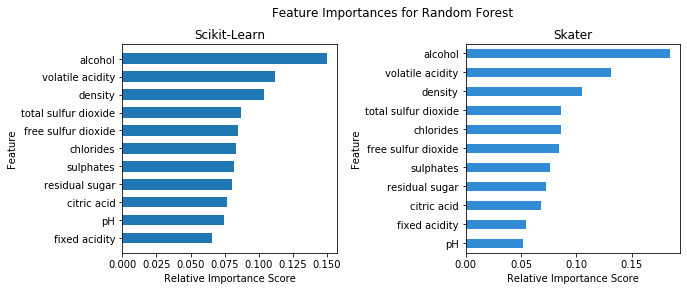

In [46]:
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel
# leveraging skater for feature importances
interpreter = Interpretation(wqp_test_SX, feature_names=wqp_feature_names)
wqp_im_model = InMemoryModel(wqp_rf.predict_proba, examples=wqp_train_SX, target_names=wqp_rf.classes_)
# retrieving feature importances from the scikit-learn estimator
wqp_rf_feature_importances = wqp_rf.feature_importances_
wqp_rf_feature_names, wqp_rf_feature_scores = zip(*sorted(zip(wqp_feature_names, wqp_rf_feature_importances), 
                                                          key=lambda x: x[1]))
# plot the feature importance plots
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
t = f.suptitle('Feature Importances for Random Forest', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.6)
y_position = list(range(len(wqp_rf_feature_names)))
ax1.barh(y_position, wqp_rf_feature_scores, height=0.6, align='center', tick_label=wqp_rf_feature_names)
ax1.set_title("Scikit-Learn")
ax1.set_xlabel('Relative Importance Score')
ax1.set_ylabel('Feature')
plots = interpreter.feature_importance.plot_feature_importance(wqp_im_model, ascending=False, ax=ax2)
ax2.set_title("Skater")
ax2.set_xlabel('Relative Importance Score')
ax2.set_ylabel('Feature')

## View Model ROC Curve

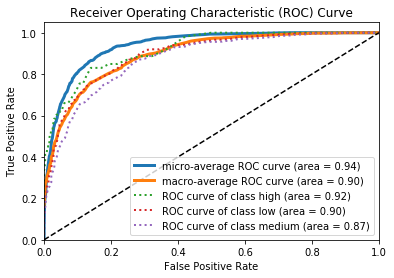

In [47]:
meu.plot_model_roc_curve(wqp_rf, wqp_test_SX, wqp_test_y)